KAGGLE + COLAB SET UP

1. Uploading kaggle.json  & moving file to correct location

In [1]:
from google.colab import files
files.upload() # upload kaggle json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"machkevds","key":"678fe96424c7399770a2ab98c064ba38"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d ./data

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:16<00:00, 108MB/s] 
100% 2.29G/2.29G [00:16<00:00, 153MB/s]


2. Exploring dataset structure &visualizing sample images

In [4]:
import os

#root folder of dataset
base_dir = "./data/chest_xray"

#loop over train val and test directories
#for each split go into its folder & subfolders "3 labels"
for split in ["train", "val", "test"]:
  split_path = os.path.join(base_dir, split)
  print(f"\n{split.upper()} SET:")

#for each label, count number of images it contains
  for label in os.listdir(split_path):
    label_path = os.path.join(split_path, label)
    count = len(os.listdir(label_path))
    print(f" - {label}: {count} images")


TRAIN SET:
 - PNEUMONIA: 3875 images
 - NORMAL: 1341 images

VAL SET:
 - PNEUMONIA: 8 images
 - NORMAL: 8 images

TEST SET:
 - PNEUMONIA: 390 images
 - NORMAL: 234 images


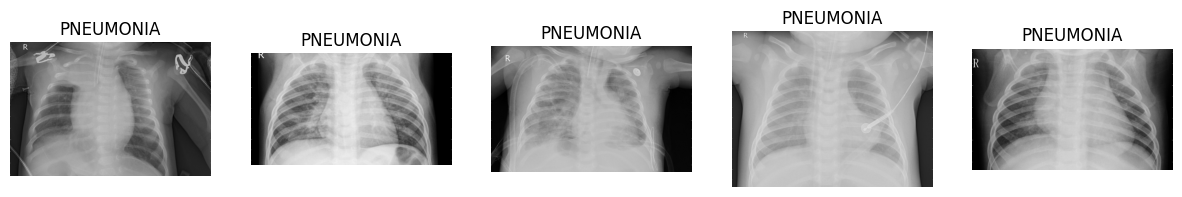

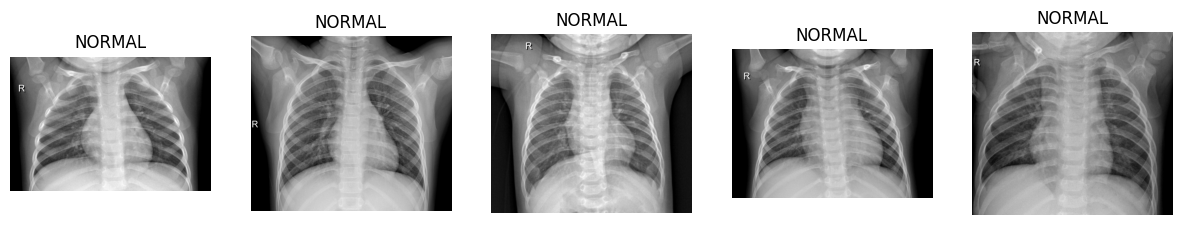

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def show_random_images(split="train", label="PNEUMONIA", num=5):
  path = os.path.join(base_dir, split, label)
  files = random.sample(os.listdir(path), num)

  plt.figure(figsize=(15,3))
  for i, f in enumerate(files):
    img = mpimg.imread(os.path.join(path, f))
    plt.subplot(1, num, i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(label)
  plt.show()

show_random_images("train", "PNEUMONIA")
show_random_images("train", "NORMAL")

3. Data Preprocessing (Keras)

In [5]:
#importing libraries and defining paths

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#set base paths
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

#set standard image size for CNNs
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

In [6]:
# create data generators

# data augmentation only for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,  #normalize pixel values
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

#normalize pixel values for test, no augmentation
val_test_datagen = ImageDataGenerator( rescale=1./255)



# flow images from all 3 directories

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode='binary'
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode='binary'
)

test_gen = val_test_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode='binary',
    shuffle = False # for confusion matrix later
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


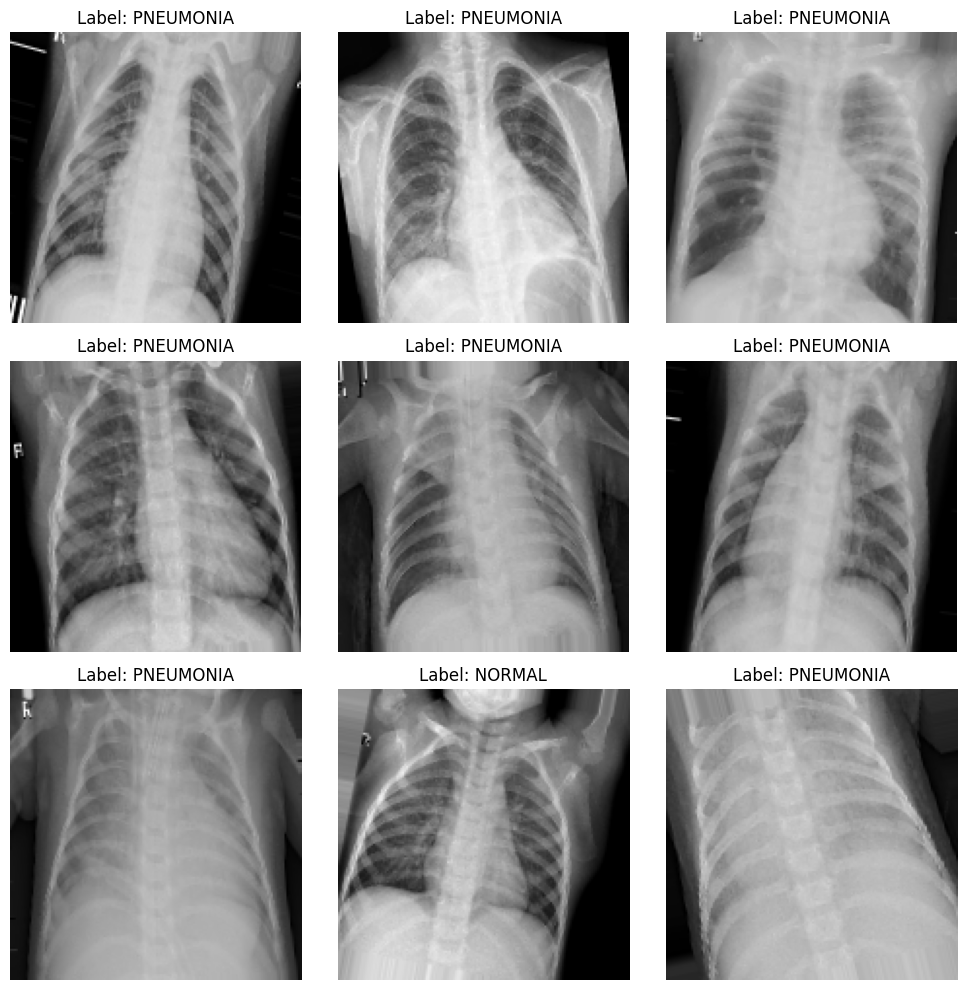

In [8]:
#preview a batch of images

import numpy as np

images, labels = next(train_gen)

plt.figure(figsize=(10,10))

for i in range(9):
  plt.subplot(3,3, i + 1)
  plt.imshow(images[i])
  plt.title(f"Label: {'PNEUMONIA' if labels[i] else 'NORMAL'}")
  plt.axis("off")
plt.tight_layout()
plt.show()

4. Building a CNN from scratch in Keras (TensorFlow)

In [14]:
# building the CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # first convolution + pooling
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2,2)),

    # second convolution + pooling
    Conv2D(64,(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    #third convolution + pooling
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # flatten & fully connect layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), #helps with overfitting
    Dense(1, activation='sigmoid') #binary classification w sigmoid
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# compile the model

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [16]:
# train the model

EPOCHS = 10

history = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 433ms/step - accuracy: 0.7780 - loss: 0.5396 - val_accuracy: 0.6875 - val_loss: 0.4966
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 422ms/step - accuracy: 0.8976 - loss: 0.2483 - val_accuracy: 0.9375 - val_loss: 0.4149
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 418ms/step - accuracy: 0.9142 - loss: 0.2169 - val_accuracy: 0.6875 - val_loss: 0.6869
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 427ms/step - accuracy: 0.9190 - loss: 0.2095 - val_accuracy: 0.6875 - val_loss: 1.3136
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 425ms/step - accuracy: 0.9225 - loss: 0.1990 - val_accuracy: 0.7500 - val_loss: 0.9243
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 431ms/step - accuracy: 0.9370 - loss: 0.1683 - val_accuracy: 0.6250 - val_loss: 1.1373
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 421ms/step - accuracy: 0.9417 - loss: 0.1702 - val_accuracy: 0.7500 - val_loss: 0.4776
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 424ms/step - accuracy: 0.9451 - loss: 0

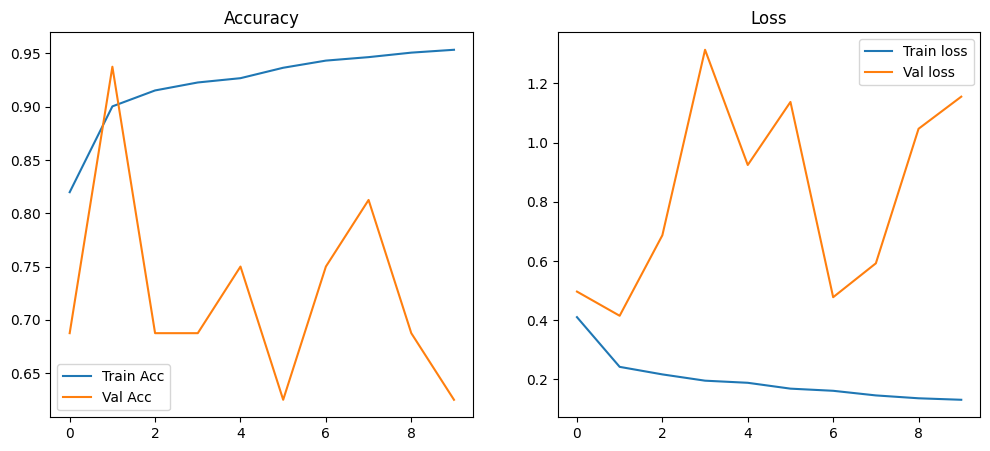

In [21]:
# plot training and validation performance

import matplotlib.pyplot as plt

def plot_training(history):
  acc= history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(12, 5))

  plt.subplot(1,2,1)
  plt.plot(acc, label="Train Acc")
  plt.plot(val_acc, label="Val Acc")
  plt.title('Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(loss, label='Train loss')
  plt.plot(val_loss, label="Val loss")
  plt.title('Loss')
  plt.legend()

  plt.show()

plot_training(history)

In [1]:
# NOTES:

# CHANGES ON KEVPOCH 1 (personal term to track my changes to the models)
# overfitting:
#so I increased dropout to 0.6, added validation_split, increased rotation_range from 15 to 30, epochs from 10 to 15
# I noticed that ImageDataGenerator is DEPRECATED, so I will definetely move to a modern approach, will use image_dataset_from_directory
# this attempt failed and caused ever worse overfitting, so now I will revert changes to original and commit on github for tracking.
# you also forgot to add the validation loss curve on the loss graph, it will now be added

In [19]:
# evaluate on the test set

test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

163/163 ━━━━━━━━━━━━━━━━━━━━ 45s 275ms/step - accuracy: 0.9627 - loss: 0.1015
Test Accuracy: 0.9709


@@@ GITHUB SETUP @@@

In [1]:
import os

# Replace with your info
os.environ['USER'] = 'machkevds'
os.environ['REPO'] = 'deep-xray-diagnosis-machkevds'

# Clone repo
%cd /content
!rm -rf {os.environ['REPO']}  # Remove old clone if needed
!git clone https://github.com/{os.environ['USER']}/{os.environ['REPO']}.git

# Go into repo
%cd /content/{os.environ['REPO']}
!git config --global user.name "machkevds"
!git config --global user.email "kevindslzr@gmail.com"


/content
Cloning into 'deep-xray-diagnosis-machkevds'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
/content/deep-xray-diagnosis-machkevds


In [ ]:
# Replace with your actual notebook name if different
notebook_name = "xray-diag-machkds.ipynb"

# Move notebook into repo folder
!mv /content/{notebook_name} /content/{os.environ['REPO']}
